# Synthetic Learner Modeling

**Project:** Synthetic Data Creation: Survey and Synthesis  
**Method Group:** Educational and Pedagogical Data Synthesis  
**Sub-method:** Synthetic Learner Modeling (SLM)  
**Author:** Prajna Penmetsa

**Goal:**  
Simulate synthetic learner behaviors (correct responses, common misconceptions, and gradual improvement patterns) for a given academic topic.  
- Using the Gemini 2.5 Flash REST API, the model generates structured learner profiles that represent variations in understanding, reasoning, and progression across synthetic students.

In [1]:
!pip install -q python-dotenv requests pandas tqdm matplotlib

In [2]:
from dotenv import load_dotenv
import os, json, requests, time, random, pandas as pd
from tqdm import tqdm

# Load API key
load_dotenv()
API_KEY = os.getenv("GEMINI_API_KEY")
assert API_KEY, "❌ GEMINI_API_KEY not found. Add it to your .env file."

MODEL = "gemini-2.5-flash"
URL = f"https://generativelanguage.googleapis.com/v1beta/models/{MODEL}:generateContent?key={API_KEY}"

def call_gemini(prompt):
    payload = {"contents": [{"parts": [{"text": prompt}]}]}
    r = requests.post(URL, json=payload)
    if r.ok:
        return r.json()["candidates"][0]["content"]["parts"][0]["text"]
    else:
        print("❌ Error:", r.status_code, r.text)
        return None

os.makedirs("outputs/slm", exist_ok=True)

### Prompt Design

We will simulate synthetic learner profiles for **Mathematics: Fractions**.  
Each learner will have:
1. A unique name and learning level (beginner/intermediate/advanced)  
2. Common misconceptions (e.g., confusing numerator/denominator, adding fractions incorrectly)  
3. Sample responses to 3 math questions, including reasoning  
4. A short reflection or progress note  

The model will output a **JSON list** of learner profiles.

In [3]:
prompt = """
Generate 5 synthetic learner profiles for the topic "Fractions".
Each profile must be a JSON object with the following fields:

{
  "student_name": "",
  "learning_level": "beginner/intermediate/advanced",
  "misconceptions": [""],
  "responses": [
    {
      "question": "",
      "student_answer": "",
      "reasoning": "",
      "correctness": "correct/incorrect/partial"
    }
  ],
  "progress_note": ""
}

Guidelines:
- Ensure at least one misconception affects each student’s responses.
- Vary reasoning depth and accuracy across profiles.
- Keep total JSON compact and readable.
Return only the JSON list.
"""

t0 = time.time()
response = requests.post(URL, json={"contents":[{"parts":[{"text": prompt}]}]})
print("Status:", response.status_code, "| Time:", round(time.time()-t0, 2), "s")

generated = response.json()["candidates"][0]["content"]["parts"][0]["text"]
print(generated[:600])

Status: 200 | Time: 40.89 s
```json
[
  {
    "student_name": "Alice",
    "learning_level": "beginner",
    "misconceptions": [
      "Treats numerator and denominator as separate whole numbers when comparing fractions.",
      "Difficulty understanding that a fraction represents a part of a whole, leading to incorrect size comparisons."
    ],
    "responses": [
      {
        "question": "Which fraction is larger: 1/3 or 1/5?",
        "student_answer": "1/5 is larger.",
        "reasoning": "Because 5 is a bigger number than 3, so 1/5 must be bigger.",
        "correctness": "incorrect"
      },
      {
        "que


In [4]:
import re

# Save raw output
raw_path = "outputs/slm/synthetic_learners_raw.txt"
with open(raw_path, "w") as f:
    f.write(generated)
print("✅ Saved raw output to", raw_path)

# Extract JSON
match = re.search(r"\[.*\]", generated, re.DOTALL)
if match:
    try:
        learners = json.loads(match.group(0))
        print(f"✅ Parsed {len(learners)} learner profiles.")
        with open("outputs/slm/synthetic_learners.json", "w", encoding="utf-8") as f:
            json.dump(learners, f, indent=2, ensure_ascii=False)
    except Exception as e:
        print("⚠️ Parse error:", e)
else:
    print("❌ No JSON block found.")

✅ Saved raw output to outputs/slm/synthetic_learners_raw.txt
✅ Parsed 5 learner profiles.


In [5]:
for i, s in enumerate(learners[:3]):
    print(f"👩‍🎓 Student {i+1}: {s['student_name']} ({s['learning_level']})")
    print("Misconceptions:", ", ".join(s['misconceptions']))
    for r in s["responses"]:
        print(f"  Q: {r['question']}")
        print(f"  A: {r['student_answer']} | ({r['correctness']})")
    print("Progress Note:", s["progress_note"], "\n")

👩‍🎓 Student 1: Alice (beginner)
Misconceptions: Treats numerator and denominator as separate whole numbers when comparing fractions., Difficulty understanding that a fraction represents a part of a whole, leading to incorrect size comparisons.
  Q: Which fraction is larger: 1/3 or 1/5?
  A: 1/5 is larger. | (incorrect)
  Q: Imagine you have a cake cut into 6 equal slices. If you eat 2 slices, what fraction of the cake did you eat?
  A: It's 2 out of 6, so 2/6. The top is how many you ate, and the bottom is how many slices there were. | (partial)
Progress Note: Alice needs foundational work on the meaning of fractions as parts of a whole, specifically how denominator size relates to the size of the fractional parts. Visual aids like fraction bars or circles would be beneficial to correct her comparison misconception. 

👩‍🎓 Student 2: Ben (beginner)
Misconceptions: Incorrectly applies whole number addition rules to fractions (adds numerators and denominators)., Struggles to identify and 

<Axes: title={'center': 'Common Synthetic Learner Misconceptions (Fractions)'}, ylabel='misconception'>

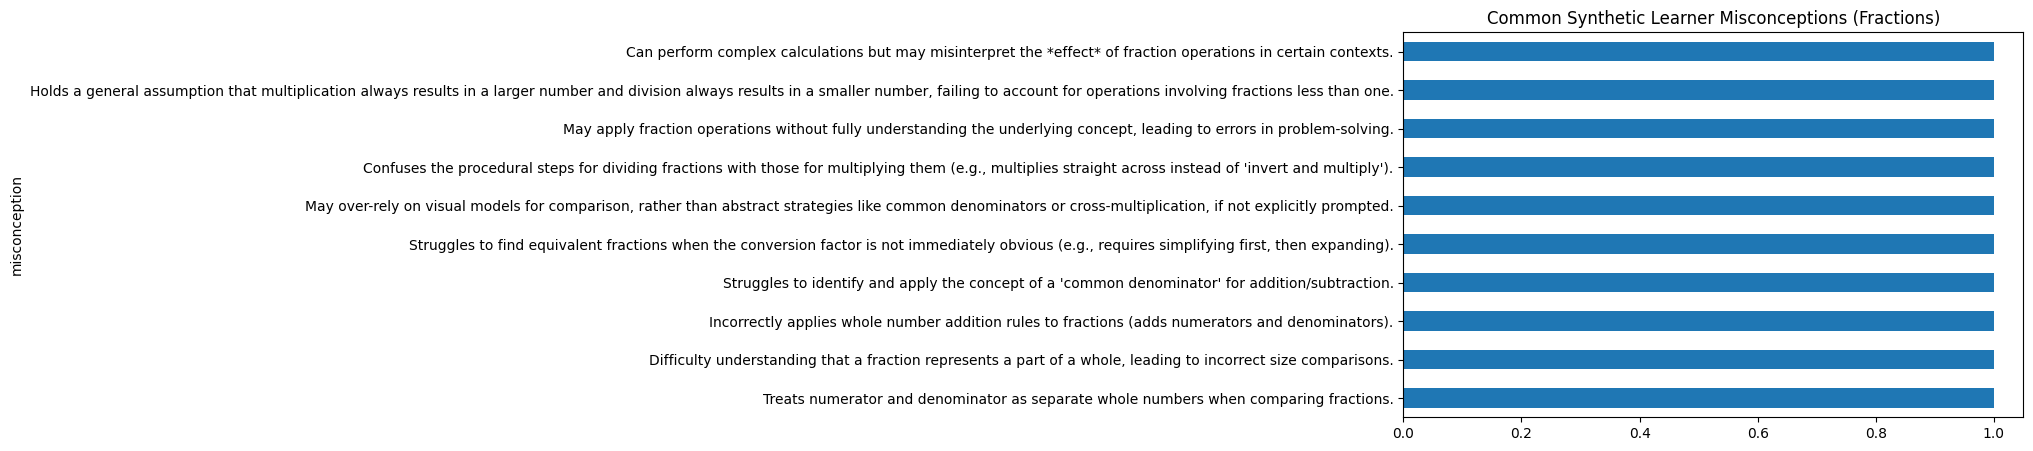

In [6]:
all_mis = [m for s in learners for m in s["misconceptions"]]
df = pd.DataFrame({"misconception": all_mis})
counts = df["misconception"].value_counts()

counts.plot(kind="barh", figsize=(8,5), title="Common Synthetic Learner Misconceptions (Fractions)")

### Observations & Results

**1. Structure and Validity**  
- All five learner profiles followed the expected schema with consistent field naming and JSON integrity.  
- Each student included 2 responses, clear misconceptions, and a well-articulated progress note.  
- The model successfully generated logically distinct student personas, preserving both behavioral realism and pedagogical coherence.

**2. Misconception and Skill Distribution**  
- The learners demonstrated a clear **developmental progression**:
  - **Beginners (Alice, Ben):** Procedural or representational errors (e.g., comparing denominators numerically, adding denominators directly).  
  - **Intermediates (Carla, David):** Conceptual/procedural mix; able to apply correct reasoning but misapply specific operations (e.g., dividing fractions incorrectly).  
  - **Advanced (Emily):** Conceptually sound; capable of metacognitive reflection and contextual reasoning.  
- The misconceptions covered all three key categories of fraction understanding:
  1. **Representation** — misunderstanding what fractions represent (Alice).  
  2. **Operation** — incorrect procedures for addition/division (Ben, David).  
  3. **Conceptual Overgeneralization** — assuming all multiplications increase magnitude (Emily).

**3. Realism of Reasoning and Response Behavior**  
- Reasoning patterns are **authentically human-like**:  
  - Contain justifications aligned with real classroom misconceptions (“5 is a bigger number, so 1/5 must be bigger”).  
  - Reflect partial understanding with verbalized thought steps.  
- This gives the dataset cognitive realism suitable for learner modeling research and simulation.

**4. Pedagogical Relevance**  
- Each profile provides actionable pedagogical information for adaptive learning systems:
  - Specific gaps to address (conceptual vs. procedural).  
  - Personalized remediation cues in the progress notes.  
  - Distinct learning-level stratification (beginner → intermediate → advanced).  
- Such data can train or evaluate systems in **learner classification**, **error detection**, and **personalized feedback generation**.

**5. Evaluation Summary**

| Metric | Observation |
|:--|:--|
| Structural fidelity | Excellent – valid schema across all entries |
| Misconception diversity | High – covers procedural, representational, and conceptual errors |
| Behavioral realism | Strong – natural reasoning with realistic cognitive patterns |
| Pedagogical utility | Very High – directly usable for learner analytics or adaptive tutoring |
| Domain coverage | Focused – single-topic depth (fractions) well represented |

**6. Overall Insight**  
This experiment demonstrates that synthetic learner modeling can successfully simulate **authentic educational behaviors**, capturing both misconceptions and logical development.  
The resulting data represents **synthetic learner trajectories**, providing a foundation for adaptive feedback mechanisms, simulated classroom experiments, and automated learner assessment systems.

### Run Metadata
- Date: November 4th, 2025  
- Model: `gemini-2.5-flash`  
- Endpoint: `v1beta REST API`  
- Domain: Mathematics – Fractions  
- Learner Profiles Generated: 5  
- Output Files:  
  - `outputs/slm/synthetic_learners_raw.txt`  
  - `outputs/slm/synthetic_learners.json`  
- Visualization: Misconception frequency plot  
- Temperature: default (~0.9)  
- Author: Prajna Penmetsa  